In [1]:
#auto-complete
%config Completer.use_jedi = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks
!ls

/content/drive/My Drive/Colab Notebooks
baseline_trained  ComputerVision4243  cs4243_smallest  model.png


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_height = 180
img_width = 180
image_size = (img_height, img_width)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243_smallest/",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243_smallest/",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

whole_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243_smallest/",
    labels='inferred',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
print(type(val_ds))
class_names = train_ds.class_names
print(class_names)

Found 1757 files belonging to 3 classes.
Using 1406 files for training.
Found 1757 files belonging to 3 classes.
Using 351 files for validation.
Found 1757 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
['carrying', 'normal', 'threat']


(16, 180, 180, 3)
(16,)


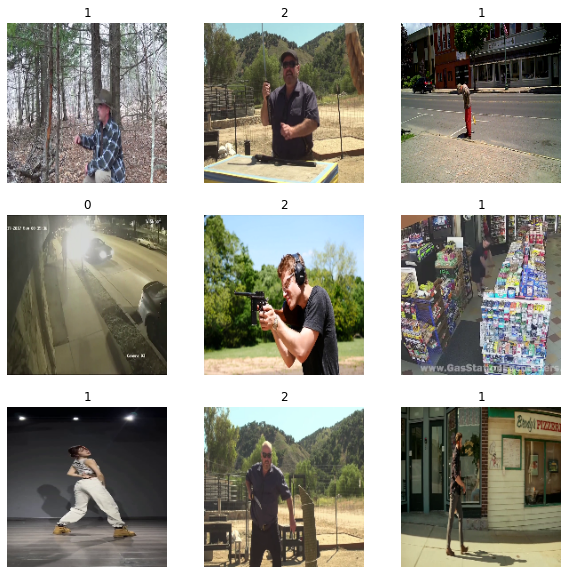

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[np.square(0.299), 
                                np.square(0.224), 
                                np.square(0.225)])
  ]
)

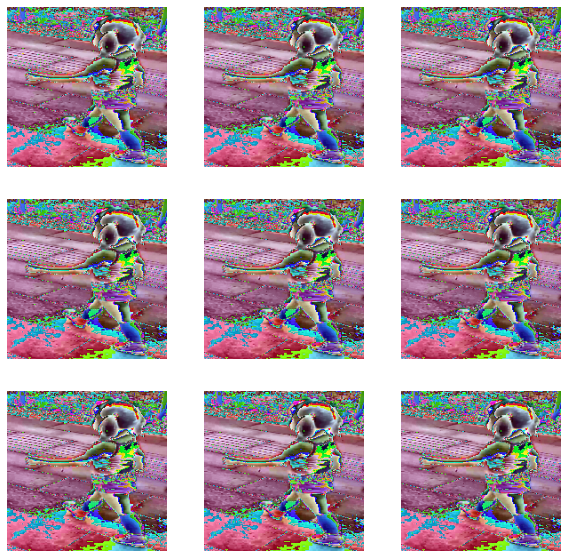

In [42]:
# showing the rotated and flipped images that were added to the 
# original dataset
#
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [43]:
#Configure the dataset for performance
augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_val_ds = val_ds.map( lambda x, y: (data_augmentation(x, training=True), y))

augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
augmented_val_ds = augmented_val_ds.prefetch(buffer_size=32)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


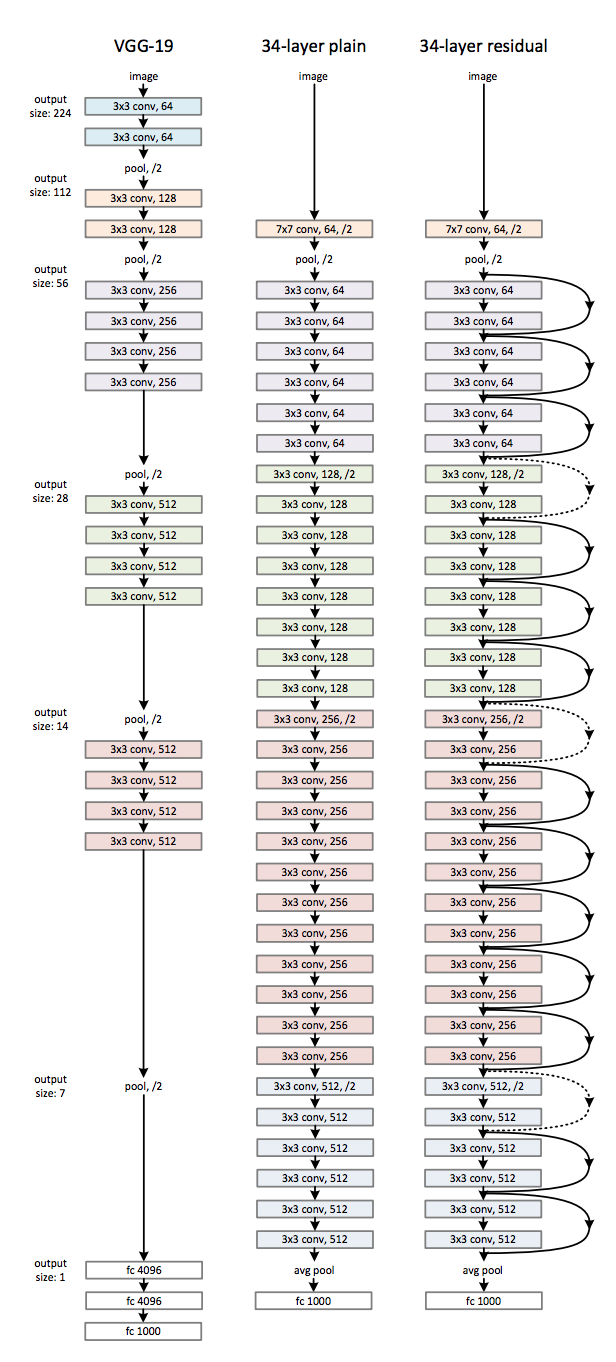

In [ ]:
# # standardization
# # starndardize values from [0, 255] to [0, 1]
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
#34 layer residual
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

classes = len(class_names)
shape = (img_height, img_width, 3)
# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, activation = 'softmax')
# ])

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (180, 180, 3), num_classes = 3):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    # standardization
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x_input)

    x = tf.keras.layers.ZeroPadding2D((3, 3))(x)# because next one is 7x7
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)


    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(len(block_layers)): 
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

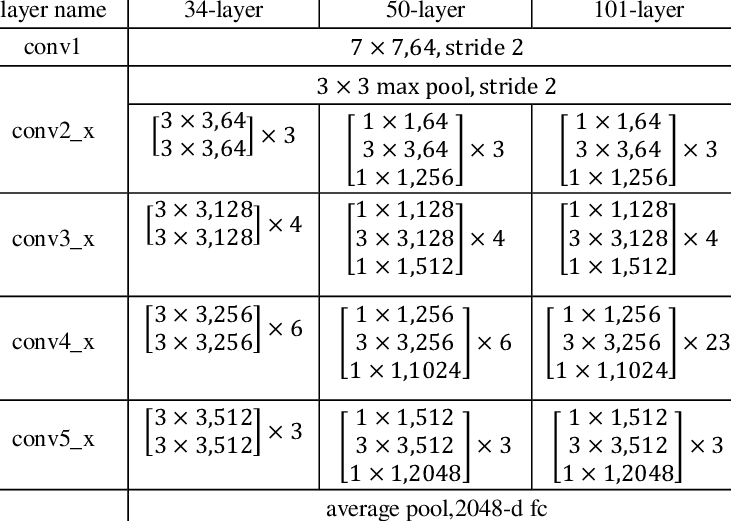

In [13]:
model = ResNet34()

In [14]:
#opimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['rescaling[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 93, 93, 64)   9472        ['zero_padding2d[0][0]']  

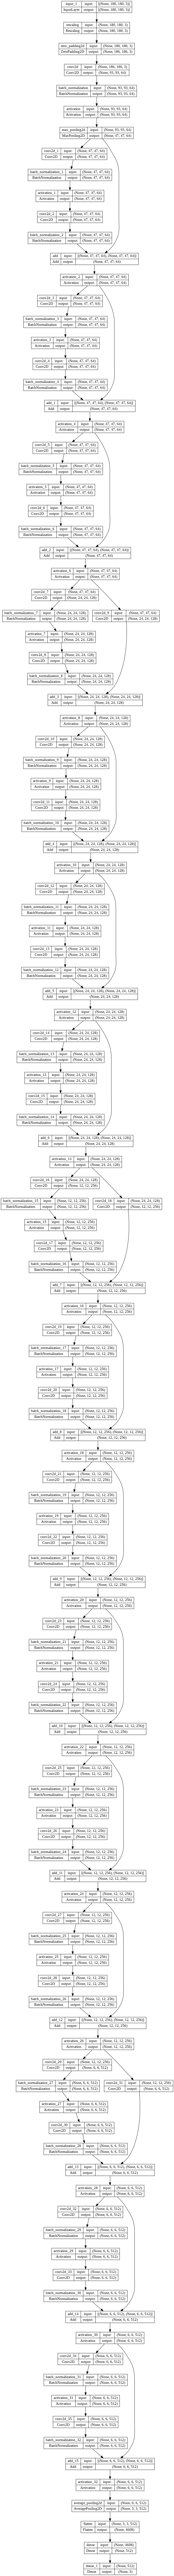

In [16]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs=10
model = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


In [ ]:
model.save('better_trained')

In [19]:
import os
import numpy as np
from os import listdir
# make confution matrix
confution_matrix = np.zeros((3,3), dtype=int)


# get the path/directory
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/better_trained')
predictions = model.predict(whole_ds)

110/110 [==============================] - 158s 1s/step


In [ ]:
predictions.shape

In [22]:
predicted_class = np.argmax(predictions, axis=1)

In [ ]:
print(predicted_class)

In [29]:
labeled_class = np.concatenate([label for img, label in whole_ds], axis = 0)

In [30]:
print(labeled_class)

[1 1 1 ... 1 2 1]


In [31]:
print(np.min(labeled_class))

0


In [32]:
print(np.max(labeled_class))

2


In [33]:
# confusion matrix
# https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
# confusion_matrix(labels, predictions)
# The rows of the matrix represent the labels
# tf.math.confusion_matrix(labeled_class, predicted_class)

confusion_matrix = tf.math.confusion_matrix(
    labeled_class,
    predicted_class,
    num_classes=3,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [34]:
print(confusion_matrix)

tf.Tensor(
[[ 29 181 106]
 [ 56 566 315]
 [ 29 306 169]], shape=(3, 3), dtype=int32)


In [35]:
print("correct 0 percentage is:", 100* confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]+confusion_matrix[2][0]))
print("correct 1 percentage is:", 100* confusion_matrix[1][1]/(confusion_matrix[0][1]+confusion_matrix[1][1]+confusion_matrix[2][1]))
print("correct 2 percentage is:", 100* confusion_matrix[2][2]/(confusion_matrix[0][2]+confusion_matrix[1][2]+confusion_matrix[2][2]))

correct 0 percentage is: tf.Tensor(25.43859649122807, shape=(), dtype=float64)
correct 1 percentage is: tf.Tensor(53.75118708452042, shape=(), dtype=float64)
correct 2 percentage is: tf.Tensor(28.64406779661017, shape=(), dtype=float64)
